In [5]:
#Adapted from the method described in 
#Bhatt, Samir, Edward C. Holmes, and Oliver G. Pybus. 2011. “The Genomic Rate of Molecular Adaptation of the Human Influenza A Virus.” Molecular Biology and Evolution 28 (9): 2443–51.
#and
#Bhatt, Samir, Aris Katzourakis, and Oliver G. Pybus. 2010. “Detecting Natural Selection in RNA Virus Populations Using Sequence Summary Statistics.” Infection, Genetics and Evolution: Journal of Molecular Epidemiology and Evolutionary Genetics in Infectious Diseases 10 (3): 421–30.

In [6]:
import math
import json
import random
from os import path
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import AlignIO
from Bio.Align import MultipleSeqAlignment
from Bio.Align import AlignInfo
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from scipy import stats


Bad key "text.kerning_factor" on line 4 in
/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [7]:
def frequency_binning(x, midfreq_high=0.75, midfreq_low=0.15):
    """
    Given the frequency of a polymorphism, return a bin (fixed, high, medium, or low)
    Default mid-frequency bin is 0.15-0.75
    This can be manually changed by suppling midfreq_high and midfreq_low arguments
    """
    #nan frequencies are when there is no sequence coverage at the given position
    if math.isnan(x):
        f_bin = float('nan')
    else:
        if x == 1.0:
            f_bin = 'f'
        elif x>=midfreq_high:
            f_bin = 'h'
        elif x<midfreq_high and x>=midfreq_low:
            f_bin = 'm'
        elif x<midfreq_low:
            f_bin='l'

    return f_bin

In [8]:
def walk_through_sites(outgroup_seq, outgroup_aa_seq, alignment_seqs, midfreq_high, midfreq_low):
    """
    Finds differences between the outgroup sequence and each sequence in the alignment
    Determines whether these differences are synonymous or nonsynonymous
    Skips sites that are ambiguous 
    Returns freq_bins: a list of polymorphic frequency bin (fixed, high, medium, low) at each site
    Returns replacement_score: a list of replacement score at each site
    Returns ingroup_bases: a list of lists. All nts that are observed at each site
    """
    #at each site, count number of viruses with polymorphism
    count_polymorphic = np.zeros(len(outgroup_seq))
    #at each site, count totaly number of viruses
    count_total_unambiguous = np.zeros(len(outgroup_seq))
    
    count_replacement_mutations = np.zeros(len(outgroup_seq))
    count_silent_mutations = np.zeros(len(outgroup_seq))
    
    #at each site, list of nucleotide from each virus
    ingroup_bases = [[] for x in range(len(outgroup_seq))]

                
    for seq in alignment_seqs:
        if len(seq) != len(outgroup_seq):
            print(seq)
        elif len(seq) == len(outgroup_seq):                   
            for pos in range(len(outgroup_seq)):
                outgroup_nt = str(outgroup_seq[pos])
                virus_nt = str(seq[pos])
                #skip ambiguous sites
                if virus_nt != 'N':
                    if outgroup_nt != 'N':
                        ingroup_bases[pos].append(virus_nt)
                        count_total_unambiguous[pos]+=1
                        if virus_nt != outgroup_nt:
                            count_polymorphic[pos]+=1
                            #determine silent or replacement
                            codon = math.floor(pos/3)
                            codon_pos = pos-(codon*3)
                            if codon_pos == 0:
                                codon_nt = virus_nt+outgroup_seq[pos+1:(pos+3)]
                            elif codon_pos == 1:
                                codon_nt = outgroup_seq[pos-1]+virus_nt+outgroup_seq[pos+1]
                            elif codon_pos == 2:
                                codon_nt = outgroup_seq[(pos-2):(pos)]+virus_nt
                                
                            if isinstance(codon_nt, str):
                                codon_nt = Seq(codon_nt)

                            codon_aa = codon_nt.translate()
                            
                            outgroup_aa = outgroup_aa_seq[codon]
                            if outgroup_aa != 'X':
                                if codon_aa != outgroup_aa:
                                    count_replacement_mutations[pos]+=1
                                elif codon_aa == outgroup_aa:
                                    count_silent_mutations[pos]+=1
                                
    polymorphic_frequencies = count_polymorphic/count_total_unambiguous
    
    replacement_score = count_replacement_mutations/count_total_unambiguous

    freq_bins = [frequency_binning(x, midfreq_high, midfreq_low) for x in polymorphic_frequencies]
    

    return freq_bins, replacement_score, ingroup_bases

In [9]:
def determine_site_type(outgroup, ingroup):
    """
    Determines site type (ala Bhatt et al, 2010)
    Site type depends on whether there are polymorphisms at a given site and, if so, how many different nts are observed 
    """
    ingroup_bases_nan = set(ingroup)
    #remove 'nan's
    ingroup_bases = {x for x in ingroup_bases_nan if pd.notna(x)}
    
    if len(ingroup_bases) == 0:
        site_type = None
    
    elif len(ingroup_bases) != 0:
        #all ingroup bases are identical
        if len(ingroup_bases) == 1:
            if outgroup in ingroup_bases:
                site_type = 1
            elif outgroup not in ingroup_bases:
                site_type = 2

        #2 different bases in ingroup
        elif len(ingroup_bases) == 2:
            if outgroup in ingroup_bases:
                site_type = 3
            elif outgroup not in ingroup_bases:
                site_type = 4

        #3 different bases in ingroup
        elif len(ingroup_bases) == 3:
            if outgroup in ingroup_bases:
                site_type = 5
            elif outgroup not in ingroup_bases:
                site_type = 6

        #4 different bases in ingroup
        elif len(ingroup_bases) == 4:
            site_type = 7
    
    return site_type

In [10]:
def fixation_polymorphism_score(outgroup, ingroup):
    """
    Returns Fi=fixation score and Pi=polymorphism score based on site type (ala Bhatt et al, 2010)
    """
    site_type = determine_site_type(outgroup, ingroup)
    
    if site_type == None:
        Fi = float('nan')
        Pi = float('nan')
    if site_type == 1:
        Fi = 0
        Pi = 0
    elif site_type == 2:
        Fi = 1
        Pi = 0
    elif site_type in [3,5,7]:
        Fi = 0
        Pi = 1
    elif site_type == 4:
        Fi = 0.5
        Pi = 0.5
    elif site_type == 6:
        Fi = (1/3)
        Pi = (2/3)
    
    return Fi, Pi

In [11]:
def assign_fi_pi(outgroup_seq, ingroup_bases):
    """
    Returns list of Fi and Pi at each position in the sequence
    """
    
    #at each site, record Fi
    Fi_all = np.zeros(len(outgroup_seq))
    
    #at each site, record Pi
    Pi_all = np.zeros(len(outgroup_seq))
    
    for pos in range(len(outgroup_seq)):
        outgroup_nt = outgroup_seq[pos]
        ingroup_nts = ingroup_bases[pos]
        Fi, Pi = fixation_polymorphism_score(outgroup_nt, ingroup_nts)
        Fi_all[pos] = Fi
        Pi_all[pos] = Pi
        
    return Fi_all, Pi_all
    
    
                            

In [12]:
def separate_clades(cov, gene):
    """
    If a virus should be divided into multiple clades, find which clade a strain belongs to from augur output
    file and return dataframe specifing the strain name and clade 
    """

    if path.exists('../'+str(cov)+'/results/clades_'+str(gene)+'.json'):
        clade_file = '../'+str(cov)+'/results/clades_'+str(gene)+'.json'
#         if gene =='spike' or gene == 's1' or gene == 's2':
#             clade_file = '../'+str(cov)+'/results/clades_spike.json'
    else:
        clade_file = '../'+str(cov)+'/results/clades_full.json'
    
    clade_lists = []
    with open(clade_file, "r") as clade_handle:
        clades = json.load(clade_handle)
        for node, v in clades['nodes'].items():
            if 'NODE' not in node:
                clade_lists.append({'clade':v['clade_membership'],
                                   'strain':node})

    clade_df = pd.DataFrame(clade_lists)
    return clade_df

In [13]:
def subset_viruses(cov, gene, window, clade, min_seqs, year_max=None, year_min= None):
    """
    Read in data from metafile, alignment file and reference file
    Partition data based on year the virus isolate was sequenced
    Temporal data will be grouped into time windows (default window is 3yrs), and only windows with more than
    min_seqs (default is 2) will be considered in the analysis
    Range of years considered by the analysis can be specified by year_max and year_min
    Also calculates the outgroup (or founder) sequence as the consensus sequence at the first time point
    """
#     input_file_outgroup = '../'+str(cov)+'/auspice/seasonal_corona_'+str(cov)+'_'+str(gene)+'_root-sequence.json'
    input_file_alignment = '../'+str(cov)+'/results/aligned_'+str(cov)+'_'+str(gene)+'.fasta'
    metafile = '../'+str(cov)+'/results/metadata_'+str(cov)+'_'+str(gene)+'.tsv'
    
    #Subset data based on time windows
    meta = pd.read_csv(metafile, sep = '\t')
    meta.drop(meta[meta['date']=='?'].index, inplace=True)
    meta.dropna(subset=['date'], inplace=True)
    meta['year'] = meta['date'].str[:4].astype('int')
    if year_max:
        meta.drop(meta[meta['year']>year_max].index, inplace=True)
    if year_min:
        meta.drop(meta[meta['year']<year_min].index, inplace=True)
    
    date_range = meta['year'].max() - meta['year'].min()
    
    
    if clade!= None:
        clade_df = separate_clades(cov, gene)
        meta = meta.merge(clade_df, on='strain')
        meta.drop(meta[meta['clade']!=clade].index, inplace=True)
    
    
    #Group viruses by time windows
    virus_time_subset = {}
    if window == 'all':
        years = str(meta['year'].min()) + '-' + str(meta['year'].max())
        virus_time_subset[years] = meta['strain'].tolist()
    else:
        date_window_start = meta['year'].min()
        date_window_end = meta['year'].min() + window
        while date_window_end <= meta['year'].max():
            years = str(date_window_start) + '-' + str(date_window_end)
            strains = meta[(meta['year']>=date_window_start) & (meta['year']<date_window_end)]['strain'].tolist()
            virus_time_subset[years] = strains
            
            #non-overlapping
#             date_window_end += window
#             date_window_start+= window
            
            #sliding window
            date_window_end += 1
            date_window_start += 1 
    
    #Only use time points with enough data:
    virus_time_subset = {k:v for k,v in virus_time_subset.items() if len(v)>=min_seqs}


    year_windows = []
    seqs_in_window = []
    
    #Find outgroup sequence from strains at first time point(to make consensus from)
    first_window = True
    first_window_strains = []
    first_window_sequences = []
    
    alignment_time_subset = {}
    
    
    for years, subset_viruses in virus_time_subset.items():
        year_windows.append(years)
        seqs_in_window.append(len(subset_viruses))
        alignment_time_subset[years] = []

        #make consensus sequence at first time point
        if first_window == True:
            first_window_strains+=subset_viruses
            first_window = False

        with open(input_file_alignment, "r") as aligned_handle:
            for virus in SeqIO.parse(aligned_handle, "fasta"):
                if virus.id in first_window_strains:
                    first_window_sequences.append(virus)
                if virus.id in subset_viruses:
                    alignment_time_subset[years].append(virus.seq)


    first_window_alignment = MultipleSeqAlignment(first_window_sequences)
    outgroup_seq = AlignInfo.SummaryInfo(first_window_alignment).dumb_consensus(ambiguous ='N')
    outgroup_aa_seq = outgroup_seq.translate()

    
    return virus_time_subset, alignment_time_subset, outgroup_seq, outgroup_aa_seq, year_windows, seqs_in_window 
    

In [14]:
def bootstrap_alignment(bootstrap_codon_order, sequences):
    """
    for each time point, create sample alignment of same size as emperical alignment
    """
    bootstrap_alignment_seqs = []
    for virus_seq in sequences:
        virus_seq_str = str(virus_seq)
        virus_codons = [virus_seq_str[i:i+3] for i in range(0, len(virus_seq_str), 3)] 
        bootstrap_virus = ''.join([virus_codons[x] for x in bootstrap_codon_order])
        bootstrap_alignment_seqs.append(bootstrap_virus)
    
    return bootstrap_alignment_seqs

In [15]:
def bootstrap_ancestral(outgroup_seq):
    """
    Sample codons from emperical ancestral sequence with replacement
    """
    outgroup_seq_str = str(outgroup_seq)
    #sample codons with replacement
    ancestral_codons = [outgroup_seq_str[i:i+3] for i in range(0, len(outgroup_seq_str), 3)] 
    bootstrap_codon_order = random.choices(range(len(ancestral_codons)), k=len(ancestral_codons))
    bootstrap_ancestral_seq = ''.join([ancestral_codons[x] for x in bootstrap_codon_order])
    bootstrap_ancestral_seq = Seq(bootstrap_ancestral_seq)
    return bootstrap_ancestral_seq, bootstrap_codon_order


In [16]:
def make_bootstrap_dataset(outgroup_seq, alignment_time_subset):
    """
    Return a bootstrapped ancestral sequence (outgroup) and bootstrapped alignment of sequences
    """
            
    bootstrap_ancestral_seq, bootstrap_codon_order = bootstrap_ancestral(outgroup_seq)
    bootstrap_ancestral_seq_aa = bootstrap_ancestral_seq.translate()
    
    bootstrap_alignment_seqs = {}
    for years, sequences in alignment_time_subset.items():
        bootstrap_sequences = bootstrap_alignment(bootstrap_codon_order, sequences)
        bootstrap_alignment_seqs[years] = bootstrap_sequences

        
    return bootstrap_ancestral_seq, bootstrap_ancestral_seq_aa, bootstrap_alignment_seqs

In [17]:
def calc_site_stats(alignment_sequences, outgroup_seq, outgroup_aa_seq, midfreq_high, midfreq_low):
    """
    Runs functions to determine frequency bins, fixations scores, polymorphism scores, 
    replacement scores and silent scores at each site
    """
    
    #Find percent polymorphism at each site
    #Also determine whether polymorphism is silent or replacement  
    

    #initiate lists to record all time windows
    frequency_bins = []
    fixation_scores = []
    polymorphism_scores = []
    replacement_scores = []
    silent_scores = []    
        

    for years, alignment_seqs in alignment_sequences.items():
  
        #calculate stats for each window separately
        freq_bins, replacement_score, ingroup_bases = walk_through_sites(outgroup_seq, outgroup_aa_seq, 
                                                                         alignment_seqs,
                                                                         midfreq_high, midfreq_low)
        Fi_all, Pi_all = assign_fi_pi(outgroup_seq, ingroup_bases)
        silent_score = 1-replacement_score

        frequency_bins.append(freq_bins)
        fixation_scores.append(Fi_all)
        polymorphism_scores.append(Pi_all)
        replacement_scores.append(replacement_score)
        silent_scores.append(silent_score)
     
    return frequency_bins, fixation_scores, polymorphism_scores, replacement_scores, silent_scores
            
            


In [18]:
def calc_m_ratio(cov, gene, window, clade, min_seqs, midfreq_high, midfreq_low, bootstrap, year_max=None, year_min= None):
    """
    Calculate the M ratio, needed for calculating 'a' in bhatt_estimators
    M=rm/sm
    Not expected to vary through time provided that long-term effective population sizes remain sufficiently large
    For each gene, M is calculated by combining site count among time points
    """
    
    if gene=='spike' or gene=='s1':
        (virus_time_subset, alignment_time_subset, 
         outgroup_seq, outgroup_aa_seq, 
         year_windows, seqs_in_window) = subset_viruses(cov, 's2', 'all', 
                                                        clade, min_seqs, year_max, year_min)
        if bootstrap:
            input_file_alignment = '../'+str(cov)+'/results/aligned_'+str(cov)+'_s2.fasta'
            (bootstrap_ancestral_seq, bootstrap_ancestral_seq_aa,
             bootstrap_alignment_seqs) = make_bootstrap_dataset(outgroup_seq, alignment_time_subset)
        
        
    else:
        (virus_time_subset, alignment_time_subset, 
         outgroup_seq, outgroup_aa_seq, 
         year_windows, seqs_in_window) = subset_viruses(cov, gene, 'all', 
                                                        clade, min_seqs, year_max, year_min)
        if bootstrap:
            input_file_alignment = '../'+str(cov)+'/results/aligned_'+str(cov)+'_'+str(gene)+'.fasta'
            (bootstrap_ancestral_seq, bootstrap_ancestral_seq_aa,
             bootstrap_alignment_seqs) = make_bootstrap_dataset(outgroup_seq, alignment_time_subset)
    
    if bootstrap:
            (frequency_bins, 
             fixation_scores, polymorphism_scores, 
             replacement_scores, silent_scores) = calc_site_stats(bootstrap_alignment_seqs, 
                                                                  bootstrap_ancestral_seq, bootstrap_ancestral_seq_aa, 
                                                                  midfreq_high, midfreq_low)
    else:
        (frequency_bins, 
         fixation_scores, polymorphism_scores, 
         replacement_scores, silent_scores) = calc_site_stats(alignment_time_subset, 
                                                              outgroup_seq, outgroup_aa_seq, midfreq_high, midfreq_low)
        
    
    sm = 0
    rm = 0
    
    for site in range(len(frequency_bins[0])):
        freq_bin = frequency_bins[0][site]
        if freq_bin == 'm':
            sm+= (polymorphism_scores[0][site]*silent_scores[0][site])
            rm+= (polymorphism_scores[0][site]*replacement_scores[0][site])
    
    if sm ==0:
        sm = 0.00000000000000001
    m_ratio = rm/sm
    
    return m_ratio

In [19]:
def bhatt_estimators(cov, gene, outgroup_seq, frequency_bins, year_windows, fixation_scores, polymorphism_scores, replacement_scores, silent_scores, m_ratio):
    """
    Calculate sf, rf, sh, rh, sm, rm, sl, rl (bhatt estimators)
    Then calculate al, ah, af
    Number of adaptive substitutions = af + ah
    Calculate these values for each time window and return:
    window_midpoint: middle year of time window 
    adaptive_substitutions: list of adaptive substitutions estimated for each time window
    adaptive_substitutions_per_codon: list of adaptive substitutions per codon estimated for each time window
    rate_of_adaptation: fit linear regression of adaptive_subtitutions_per_codon vs time
    """
    
    #Initiate lists to store a values
    window_midpoint = []
    adaptive_substitutions = []
    
    #for each window, calculate bhatt estimators 
    for years_window in range(len(frequency_bins)):
        window_start = int(year_windows[years_window][0:4])
        window_end = int(year_windows[years_window][-4:])
        window_midpoint.append((window_start + window_end)/2)

        sf = 0
        rf = 0
        sh = 0
        rh = 0
        sm = 0
        rm = 0
        sl = 0
        rl = 0

        #calculate number of sites in different catagories (defined by polymorphic freq at that site)
        window_freq_bins = frequency_bins[years_window]
        for site in range(len(window_freq_bins)):
            freq_bin = window_freq_bins[site]
            #ignore sites with no polymorphisms?
            if freq_bin!='nan':
                if freq_bin == 'f':
                    sf+= (fixation_scores[years_window][site]*silent_scores[years_window][site])
                    rf+= (fixation_scores[years_window][site]*replacement_scores[years_window][site])
                elif freq_bin == 'h':
                    sh+= (polymorphism_scores[years_window][site]*silent_scores[years_window][site])
                    rh+= (polymorphism_scores[years_window][site]*replacement_scores[years_window][site])
                elif freq_bin == 'm':
                    sm+= (polymorphism_scores[years_window][site]*silent_scores[years_window][site])
                    rm+= (polymorphism_scores[years_window][site]*replacement_scores[years_window][site])
                elif freq_bin == 'l':
                    sl+= (polymorphism_scores[years_window][site]*silent_scores[years_window][site])
                    rl+= (polymorphism_scores[years_window][site]*replacement_scores[years_window][site])       

#             print(year_windows[years_window])
#             print(sf, rf, sh, rh, sm, rm, sl, rl)  

        #Calculate equation 1: number of nonneutral sites
        al = rl - sl*m_ratio
        ah = rh - sh*m_ratio
        af = rf - sf*m_ratio
        #set negative a values to zero
        if al < 0:
            al = 0
        if ah < 0:
            ah = 0
        if af < 0:
            af = 0

#             print(al, ah, af)

        #Calculate the number and proportion of all fixed or high-freq sites that have undergone adaptive change
        number_adaptive_substitutions = af + ah
        adaptive_substitutions.append(number_adaptive_substitutions)
#         proportion_adaptive_sites = (af + ah)/(rf +rh)

    
    gene_length = len(outgroup_seq)
    adaptive_substitutions_per_codon = [x/gene_length for x in adaptive_substitutions]
    
    if len(window_midpoint)!=0:
        rate_of_adaptation, intercept, r_value, p_value, std_err = stats.linregress(window_midpoint, adaptive_substitutions_per_codon)
    else:
        rate_of_adaptation = 0
            
    return window_midpoint, adaptive_substitutions, adaptive_substitutions_per_codon, rate_of_adaptation
        

In [20]:
def calc_bhatt_a(cov, gene, window, clade, min_seqs, midfreq_high, midfreq_low, bootstrap, year_max=None, year_min=None):
    """
    Run all functions to calculate 'a'
    If data should be bootstrapped, also make bootstrapped outgroups and alignments and calculate 'a' on these
    """
    #Get virus subset
    (virus_time_subset, alignment_time_subset, 
     outgroup_seq, outgroup_aa_seq, year_windows, seqs_in_window) = subset_viruses(cov, gene, 
                                                                                   window, clade, min_seqs, 
                                                                                   year_max, year_min)
#     print(alignment_time_subset, [len(alignment_time_subset[x]) for x in alignment_time_subset.keys()], seqs_in_window)
    #Calculate frequencies for emperical data
    (frequency_bins, 
     fixation_scores, polymorphism_scores, 
     replacement_scores, silent_scores) = calc_site_stats(alignment_time_subset, outgroup_seq, 
                                                          outgroup_aa_seq, midfreq_high, midfreq_low)
    
    
    #calculate m ratio
    m_ratio = calc_m_ratio(cov, gene, window, 
                           clade, min_seqs, midfreq_high, midfreq_low, False, 
                           year_max, year_min)
    
    
    #calculate bhatt estimators
    (window_midpoint, adaptive_substitutions, 
     adaptive_substitutions_per_codon, rate_of_adaptation) = bhatt_estimators(cov, gene, outgroup_seq, 
                                                                              frequency_bins, year_windows, 
                                                                              fixation_scores, polymorphism_scores, 
                                                                              replacement_scores, silent_scores, m_ratio)
    
    
    n_bootstraps = 100
    bootstrap_count = 0
    
    bootstrap_adaptive_substitutions = []
    bootstrap_adaptive_substitutions_per_codon = []
    bootstrap_rate_of_adaptation = []
    if bootstrap:
        while bootstrap_count < n_bootstraps:
            bootstrap_count+=1
            if bootstrap_count%100 == 0:
                print(f'{bootstrap_count} bootstraps done for {cov} {gene}')
            #Get bootstrapped ancestral seq and alignment
            input_file_alignment = '../'+str(cov)+'/results/aligned_'+str(cov)+'_'+str(gene)+'.fasta'
            (bootstrap_ancestral_seq, bootstrap_ancestral_seq_aa,
             bootstrap_alignment_seqs) = make_bootstrap_dataset(outgroup_seq, alignment_time_subset)


            #Calculate frequencies for bootstrap data
            (bootstrap_frequency_bins, 
             bootstrap_fixation_scores, bootstrap_polymorphism_scores, 
             bootstrap_replacement_scores, bootstrap_silent_scores) = calc_site_stats(bootstrap_alignment_seqs, 
                                                                                      bootstrap_ancestral_seq, 
                                                                                      bootstrap_ancestral_seq_aa, 
                                                                                      midfreq_high, midfreq_low)
            #Calculate m ratio
            bootstrap_m_ratio = calc_m_ratio(cov, gene, window, 
                                             clade, min_seqs, midfreq_high, midfreq_low, True,  
                                             year_max, year_min)

            #calculate bhatt estimators
            (bs_window_midpoint, bs_adaptive_substitutions, 
             bs_adaptive_substitutions_per_codon, 
             bs_rate_of_adaptation) = bhatt_estimators(cov, gene, bootstrap_ancestral_seq, 
                                                              bootstrap_frequency_bins, year_windows, 
                                                              bootstrap_fixation_scores, 
                                                              bootstrap_polymorphism_scores, 
                                                              bootstrap_replacement_scores, bootstrap_silent_scores, 
                                                              bootstrap_m_ratio)
            #add these bootstrap values to list
            bootstrap_adaptive_substitutions.append(bs_adaptive_substitutions)
            bootstrap_adaptive_substitutions_per_codon.append(bs_adaptive_substitutions_per_codon)
            bootstrap_rate_of_adaptation.append(bs_rate_of_adaptation)
    
    if bootstrap:
        return window_midpoint, adaptive_substitutions, adaptive_substitutions_per_codon, rate_of_adaptation, bootstrap_adaptive_substitutions, bootstrap_adaptive_substitutions_per_codon, bootstrap_rate_of_adaptation

    else:
        return window_midpoint, adaptive_substitutions, adaptive_substitutions_per_codon, rate_of_adaptation


In [32]:
def plot_adaptive_subs_per_codon(cov, genes, window, clade, min_seqs, midfreq_high, midfreq_low, bootstrap, year_max=None, year_min=None, filename=None):
    """
    For a given virus and any number of genes, plot time on x and adaptive subsititions per codon on y.
    Calculations will be saved as .json files in /bhatt_results directory so they do not have to be rerun
    If new data is acquired for a virus, these will need to be deleted before rerunning this plotting function
    """
    
    data_to_plot = []
    
#     color_map = {'229e':'#2E86C1', 'oc43': '#CB4335', 'nl63': '#009888', 'hku1': '#7c5295'}
    color_map = {'oc43A': '#208288', 'oc43B':'#76C7BE',  '229e': '#0B194C', 
                 'nl63A': '#87C735', 'nl63B': '#009888', 'nl63': '#87C735',
                 'hku1A': '#2E74B3', 'hku1B': '#92B2DE', 'hku1': '#255191'}  
    
    for gene in genes:
        if bootstrap:
            save_json_name = 'bhatt_results/'+str(cov)+str(clade)+'_'+str(gene)+'_bhatt_analysis_bootstrapped.json'
            if path.exists(save_json_name):
                with open(save_json_name) as json_handle:
                    json_dict = json.load(json_handle)
                    (window_midpoint, adaptive_substitutions, 
                     adaptive_substitutions_per_codon, 
                     rate_of_adaptation, bootstrap_adaptive_substitutions, 
                     bootstrap_adaptive_substitutions_per_codon, 
                     bootstrap_rate_of_adaptation) = (json_dict['window_midpoint'], 
                                                      json_dict['adaptive_substitutions'], 
                                                      json_dict['adaptive_substitutions_per_codon'], 
                                                      json_dict['rate_of_adaptation'], 
                                                      json_dict['bootstrap_adaptive_substitutions'], 
                                                      json_dict['bootstrap_adaptive_substitutions_per_codon'], 
                                                      json_dict['bootstrap_rate_of_adaptation'])

            else:
                (window_midpoint, adaptive_substitutions, 
                 adaptive_substitutions_per_codon, 
                 rate_of_adaptation, bootstrap_adaptive_substitutions, 
                 bootstrap_adaptive_substitutions_per_codon, 
                 bootstrap_rate_of_adaptation) = calc_bhatt_a(cov, gene, window, 
                                                              clade, min_seqs, midfreq_high, 
                                                              midfreq_low, bootstrap, year_max, year_min)
                save_json = {'cov': cov, 'gene': gene, 'window':window, 'clade':clade, 'min_seqs': min_seqs, 
                             'midfreq_high': midfreq_high, 'midfreq_low': midfreq_low,
                             'window_midpoint':window_midpoint, 'adaptive_substitutions':adaptive_substitutions, 
                             'adaptive_substitutions_per_codon':adaptive_substitutions_per_codon, 'rate_of_adaptation': rate_of_adaptation,
                             'bootstrap_adaptive_substitutions': bootstrap_adaptive_substitutions, 
                             'bootstrap_adaptive_substitutions_per_codon': bootstrap_adaptive_substitutions_per_codon, 
                             'bootstrap_rate_of_adaptation':bootstrap_rate_of_adaptation}
                with open(save_json_name, 'w') as outfile:
                    json.dump(save_json, outfile)
                    
        else:
            save_json_name = 'bhatt_results/'+str(cov)+str(clade)+'_'+str(gene)+'_bhatt.json'
            if path.exists(save_json_name):
                with open(save_json_name) as json_handle:
                    json_dict = json.load(json_handle)
                    (window_midpoint, adaptive_substitutions, 
                     adaptive_substitutions_per_codon, 
                     rate_of_adaptation) = (json_dict['window_midpoint'], 
                                            json_dict['adaptive_substitutions'], 
                                            json_dict['adaptive_substitutions_per_codon'], 
                                            json_dict['rate_of_adaptation'])
                    
            else:
                (window_midpoint, adaptive_substitutions, 
                 adaptive_substitutions_per_codon, 
                 rate_of_adaptation) = calc_bhatt_a(cov, gene, window, clade, min_seqs, 
                                                    midfreq_high, midfreq_low, 
                                                    bootstrap, year_max, year_min)
        
        for year in range(len(window_midpoint)):
            if clade!=None:
                data_to_plot.append({'cov': cov, 'clade': clade, 'gene': gene, 'data_plotted': cov+clade,
                                     'year': window_midpoint[year], 
                                     'adaptive_subs_per_codon': adaptive_substitutions_per_codon[year]})
            elif clade==None:
                data_to_plot.append({'cov': cov, 'clade': clade, 'gene': gene, 'data_plotted': cov,
                                     'year': window_midpoint[year], 
                                     'adaptive_subs_per_codon': adaptive_substitutions_per_codon[year]})
            if bootstrap:
                num_bootstraps = range(len(bootstrap_adaptive_substitutions_per_codon))
                for bootstrap_iteration in num_bootstraps:
                    bs_adaptive_subs = 'bs_subs_'+str(bootstrap_iteration)
                    color_map['bs'+str(bootstrap_iteration)] = '#E5E5E5'
                    data_to_plot.append({'cov': cov, 'gene': gene, 'data_plotted': 'bs'+str(bootstrap_iteration),
                                         'year': window_midpoint[year], 
                                         bs_adaptive_subs: bootstrap_adaptive_substitutions_per_codon[bootstrap_iteration][year]})
                    
            
        
    df_to_plot = pd.DataFrame(data_to_plot)
    
    
    sns.set(font_scale=2.0)
    sns.set_style("white")
    
    
    g = sns.FacetGrid(df_to_plot, col='gene', col_wrap=2, hue='data_plotted', height=6, aspect=1,
                      palette=color_map, sharey=True, sharex=False)
    

    
    #plot distribution of bootstrap regression lines
    if bootstrap:
        for bootstrap_iteration in num_bootstraps:
            g = g.map(sns.regplot, 'year', 'bs_subs_'+str(bootstrap_iteration), ci = None, scatter=False)
            if bootstrap_iteration%100 == 0:
                print(f'{bootstrap_iteration} plots done for {cov} {gene}')
        
        backgroundartists = []
        for ax in g.axes.flat:
            for l in ax.lines + ax.collections:
                l.set_zorder(1)
                backgroundartists.append(l)
            
    #plot emprical data with regression line
#     g = g.map(sns.regplot, 'year', 'adaptive_subs_per_codon', ci=None)
    g.map(sns.regplot, 'year', 'adaptive_subs_per_codon', ci=None)
    
    if bootstrap:
        for ax in g.axes.flat:
            for l in ax.lines + ax.collections:
                if l not in backgroundartists:
                    l.set_zorder(5)
                    
    # Iterate thorugh each axis
    for ax in g.axes.flat:
        ax.tick_params(axis='both', which='major', labelsize=16)
        
        # Make x and y-axis labels slightly larger
        ax.set_xlabel(ax.get_xlabel(), fontsize='medium')
        if ax.get_ylabel():
            ax.set_ylabel('Adaptive Subs per Codon', fontsize='medium')

        # Make title more human-readable and larger
        if ax.get_title():
            ax.set_title(ax.get_title().split('=')[1],
                         fontsize='medium')

        # Make right ylabel more human-readable and larger
        # Only the 2nd and 4th axes have something in ax.texts
        if ax.texts:
            txt = ax.texts[0]
            ax.text(txt.get_unitless_position()[0], txt.get_unitless_position()[1],
                    txt.get_text().split('=')[1],
                    transform=ax.transAxes,
                    va='center',
                    fontsize='medium')
            # Remove the original text
            ax.texts[0].remove()


    
    
    #plot error bars
#     g = g.map(sns.pointplot, 'year', 'bs_adaptive_subs_per_codon', ci = 95, color='grey', join=False, capsize=.2)

    
    
    if filename:
        g.savefig(filename, dpi=300)
    
    
    

/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide
/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide


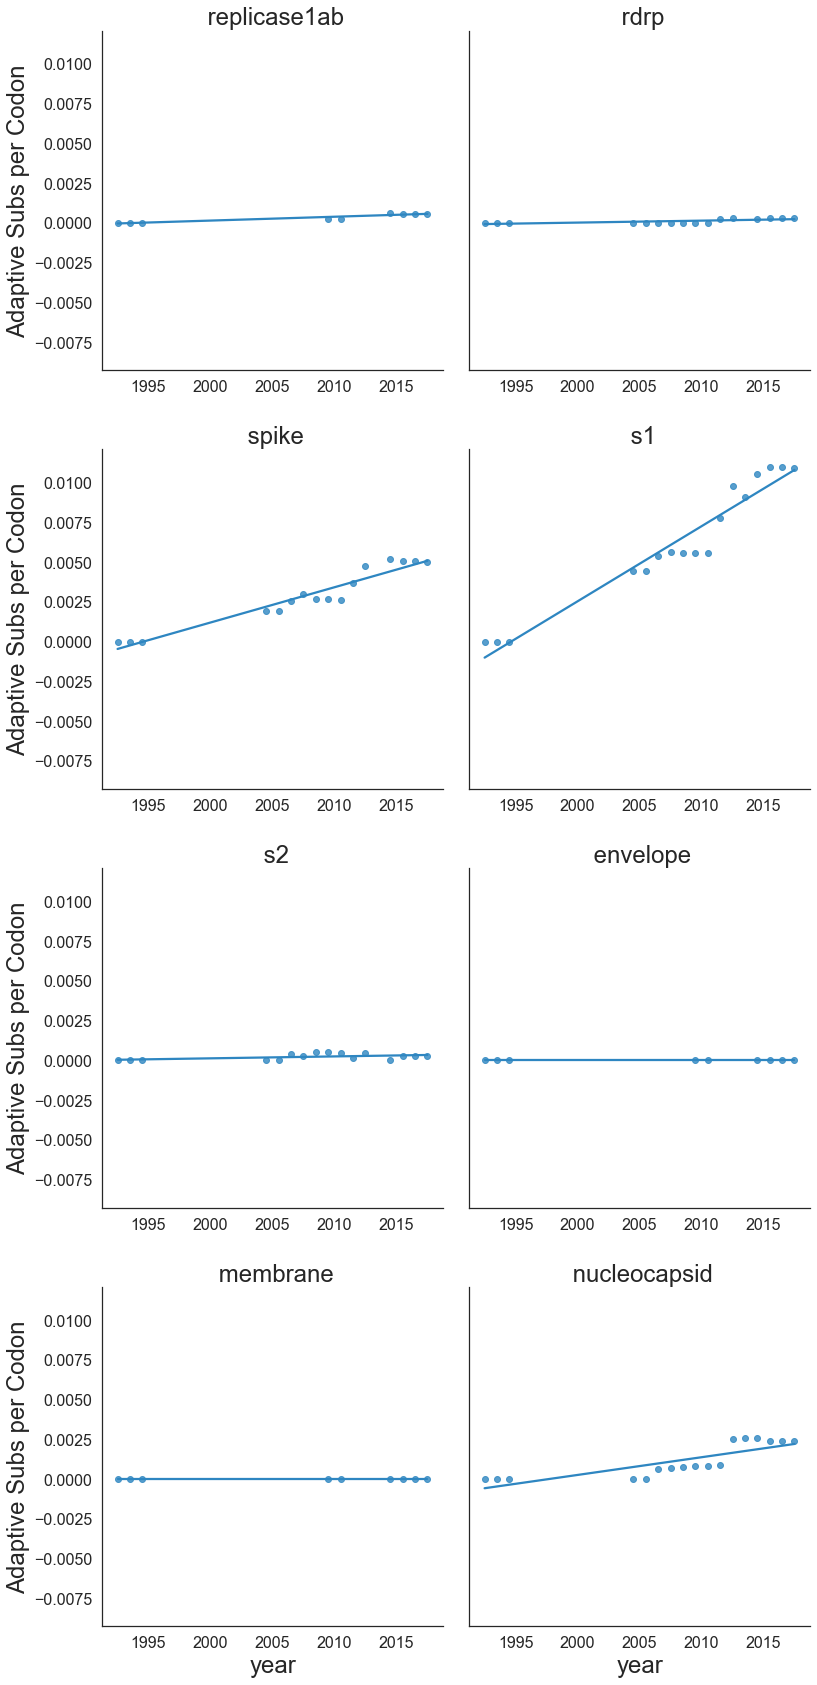

In [50]:
plot_adaptive_subs_per_codon('229e', ['replicase1ab', 'rdrp', 'spike', 
                                      's1', 's2', 'envelope', 'membrane', 'nucleocapsid'], 
                             3, None, 2, 0.75, 0.15, False)

/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide
/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide


100 bootstraps done for oc43 replicase1ab
100 bootstraps done for oc43 he
100 bootstraps done for oc43 envelope
100 bootstraps done for oc43 membrane
100 bootstraps done for oc43 nucleocapsid
0 plots done for oc43 nucleocapsid


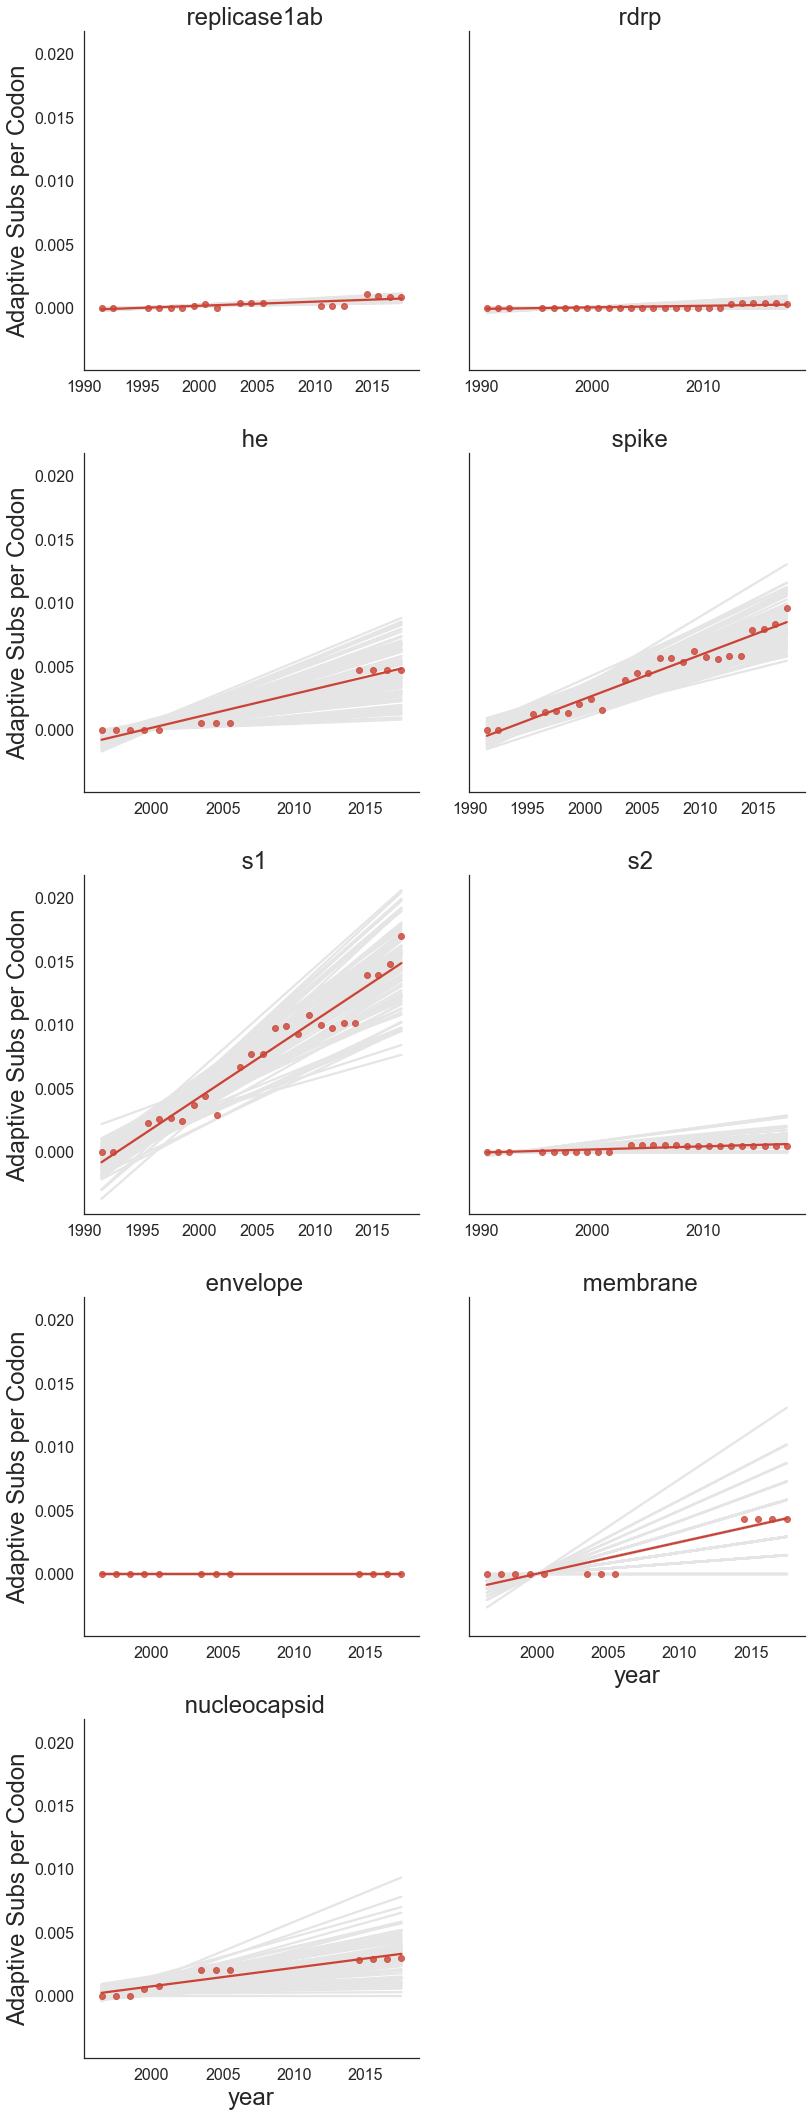

In [51]:
plot_adaptive_subs_per_codon('oc43', ['replicase1ab', 'rdrp', 'he', 'spike', 
                                      's1', 's2', 'envelope', 'membrane', 'nucleocapsid'], 
                             3, 'A', 2, 0.75, 0.15, True)



0 plots done for oc43 rdrp


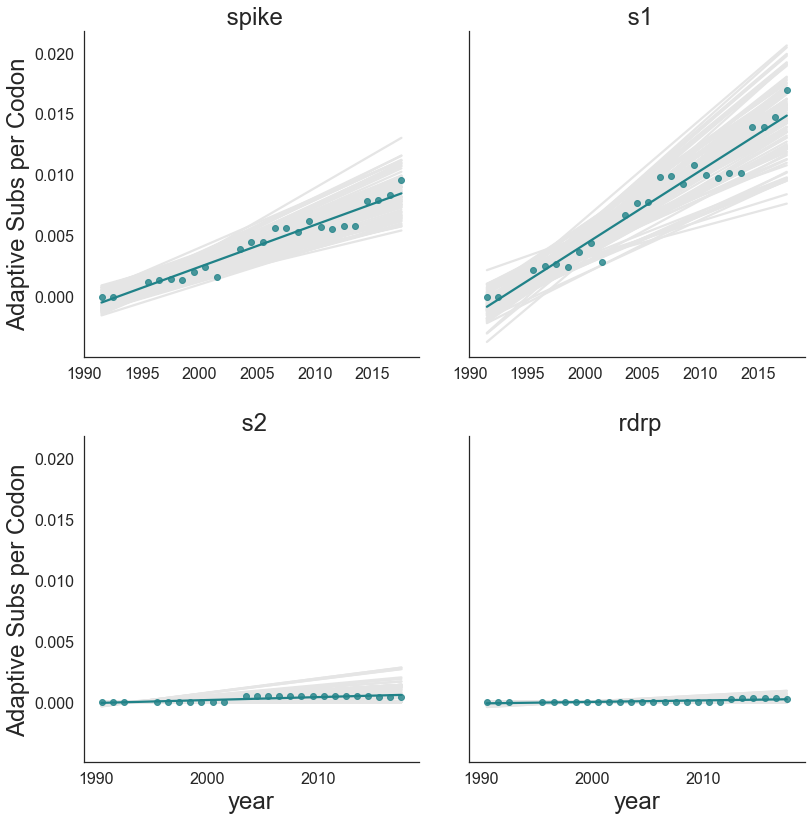

In [58]:
#100 bootstraps
plot_adaptive_subs_per_codon('oc43', ['spike', 's1', 's2', 'rdrp'], 
                             3, 'A', 3, 0.75, 0.15, True, filename='figure4_new.png')



In [54]:
#calculated as slope of adaptive subs per codon
def plot_adaptive_subs_per_codon_per_year_slope(covs, genes, window, min_seqs, midfreq_high, midfreq_low, bootstrap, year_max=None, year_min=None, filename=None):
    """
    For any number of viruses and any number of genes, plot gene on x and adaptive subsititions per 
    codon per year on y, colored by virus.
    Calculations will be saved as .json files in /bhatt_results directory so they do not have to be rerun
    If new data is acquired for a virus, these will need to be deleted before rerunning this plotting function
    """
    data_to_plot = []
    
    cov_clades = {'229e': [None], 'oc43': ['A', 'B'], 'nl63': [None], 'hku1': ['A', 'B']}

    for cov in covs:
        clades = cov_clades[cov]
        for clade in clades:
            for gene in genes:
                #some covs have different genes, only run if cov has data for this gene
#                 if path.exists(f"../{cov}/results/metadata_{cov}_{gene}.tsv"):
                if clade == None:
                    cov_clade = cov
                elif clade != None:
                    cov_clade = str(cov)+str(clade)


                if bootstrap:
                    if clade == None:
                        save_json_name = 'bhatt_results/'+str(cov)+'_'+str(gene)+'_bhatt_analysis_bootstrapped.json'
                    elif clade != None:
                        save_json_name = 'bhatt_results/'+str(cov)+str(clade)+'_'+str(gene)+'_bhatt_analysis_bootstrapped.json'

                    if path.exists(save_json_name):
                        with open(save_json_name) as json_handle:
                            json_dict = json.load(json_handle)
                            (window_midpoint, adaptive_substitutions, 
                             adaptive_substitutions_per_codon, 
                             rate_of_adaptation, bootstrap_adaptive_substitutions, 
                             bootstrap_adaptive_substitutions_per_codon, 
                             bootstrap_rate_of_adaptation) = (json_dict['window_midpoint'], 
                                                              json_dict['adaptive_substitutions'], 
                                                              json_dict['adaptive_substitutions_per_codon'], 
                                                              json_dict['rate_of_adaptation'], 
                                                              json_dict['bootstrap_adaptive_substitutions'], 
                                                              json_dict['bootstrap_adaptive_substitutions_per_codon'], 
                                                              json_dict['bootstrap_rate_of_adaptation'])

                    else:
                        (window_midpoint, adaptive_substitutions, 
                         adaptive_substitutions_per_codon, 
                         rate_of_adaptation, bootstrap_adaptive_substitutions, 
                         bootstrap_adaptive_substitutions_per_codon, 
                         bootstrap_rate_of_adaptation) = calc_bhatt_a(cov, gene, window, 
                                                                      clade, min_seqs, midfreq_high, 
                                                                      midfreq_low, bootstrap, year_max, year_min)
                        save_json = {'cov': cov, 'gene': gene, 'window':window, 'clade':clade, 'min_seqs': min_seqs, 
                                     'midfreq_high': midfreq_high, 'midfreq_low': midfreq_low,
                                     'window_midpoint':window_midpoint, 'adaptive_substitutions':adaptive_substitutions, 
                                     'adaptive_substitutions_per_codon':adaptive_substitutions_per_codon, 'rate_of_adaptation': rate_of_adaptation,
                                     'bootstrap_adaptive_substitutions': bootstrap_adaptive_substitutions, 
                                     'bootstrap_adaptive_substitutions_per_codon': bootstrap_adaptive_substitutions_per_codon, 
                                     'bootstrap_rate_of_adaptation':bootstrap_rate_of_adaptation}
                        with open(save_json_name, 'w') as outfile:
                            json.dump(save_json, outfile)

                    slope_sci = rate_of_adaptation * (10**3)
                    bs_slope_sci = [x * (10**3) for x in bootstrap_rate_of_adaptation]
                    lower_95ci = np.percentile(sorted(bs_slope_sci), 2.5)
                    upper_95ci = np.percentile(sorted(bs_slope_sci), 97.5)

                    data_to_plot.append({'cov': cov, 'gene': gene, 'cov_clade': cov_clade,
                                         'adaptive_subs_per_codon_per_year': slope_sci, 
                                         'lower_95ci': lower_95ci, 'upper_95ci': upper_95ci, 
                                         'ci': [lower_95ci, upper_95ci]})



                else:
                    if clade == None:
                        save_json_name = 'bhatt_results/'+str(cov)+'_'+str(gene)+'_bhatt_analysis.json'
                    elif clade != None:
                        save_json_name = 'bhatt_results/'+str(cov)+str(clade)+'_'+str(gene)+'_bhatt_analysis.json'
                    if path.exists(save_json_name):
                        with open(save_json_name) as json_handle:
                            json_dict = json.load(json_handle)
                            (window_midpoint, adaptive_substitutions, 
                             adaptive_substitutions_per_codon, 
                             rate_of_adaptation) = (json_dict['window_midpoint'], 
                                                              json_dict['adaptive_substitutions'], 
                                                              json_dict['adaptive_substitutions_per_codon'], 
                                                              json_dict['rate_of_adaptation'])
                    else:
                        (window_midpoint, adaptive_substitutions, 
                         adaptive_substitutions_per_codon, 
                         rate_of_adaptation) = calc_bhatt_a(cov, gene, window, clade, min_seqs, 
                                                            midfreq_high, midfreq_low, 
                                                            bootstrap, year_max, year_min)
                        save_json = {'cov': cov, 'gene': gene, 'window':window, 'clade':clade, 'min_seqs': min_seqs, 
                                     'midfreq_high': midfreq_high, 'midfreq_low': midfreq_low,
                                     'window_midpoint':window_midpoint, 'adaptive_substitutions':adaptive_substitutions, 
                                     'adaptive_substitutions_per_codon':adaptive_substitutions_per_codon, 
                                     'rate_of_adaptation': rate_of_adaptation}
                        with open(save_json_name, 'w') as outfile:
                            json.dump(save_json, outfile)
                            
                    slope_sci = rate_of_adaptation * (10**3)
                    data_to_plot.append({'cov': cov, 'gene': gene, 'cov_clade': cov_clade,
                     'adaptive_subs_per_codon_per_year': slope_sci})

            

                
        
    df_to_plot = pd.DataFrame(data_to_plot)
    
    sns.set(font_scale=1.0)
    sns.set_style("white")
    
    color_map = {'oc43A': '#208288', 'oc43B':'#76C7BE',  '229e': '#0B194C', 
                 'nl63A': '#87C735', 'nl63B': '#009888', 'nl63': '#87C735',
                 'hku1A': '#2E74B3', 'hku1B': '#92B2DE', 'hku1': '#255191'}  
    

    cov_clades = list(df_to_plot['cov_clade'].unique())
    
    x_coords = {}
    
    all_x_ticks = []
    last_coord = 0.0
    for gene in genes:
        x_coords[gene] = {}
        for cov_clade in cov_clades:
            last_coord+=0.25
            x_coords[gene][cov_clade] = last_coord
            all_x_ticks.append(last_coord)
        last_coord+=1.0
    
    fig, ax = plt.subplots(figsize=(15,8))
    
    x_labels = []
    gene_ticks = []
    
    for gene in genes:
        gene_coords = list(x_coords[gene].values())
        gene_ticks.append(sum(gene_coords)/len(gene_coords))
        x_labels.append(gene)
        for cov_clade in cov_clades:
            x = x_coords[gene][cov_clade]
            df_row = df_to_plot[(df_to_plot['gene']==gene)&(df_to_plot['cov_clade']==cov_clade)]
            y = float(df_row['adaptive_subs_per_codon_per_year'])
            if bootstrap:
                err_lower = float(df_row['lower_95ci'])
                err_upper = float(df_row['upper_95ci'])
                ax.vlines( x, err_lower, err_upper)
            ax.plot(x, y, 'o', ms=14, color=color_map[cov_clade])
    
    
    plt.xticks(gene_ticks, x_labels)
    
    legend_markers = []
    for cov_clade in cov_clades:
        legend_markers.append(mlines.Line2D([0], [0], color='w', markerfacecolor=color_map[cov_clade], marker='o',
                                            markersize=12, label=cov_clade))
    plt.legend(handles=legend_markers, loc='upper right')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax.set_ylabel('adaptive subs per codon per year (x10^-3)', fontsize=16)
    ax.set_xlabel("gene", fontsize=16)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
    
    if filename:
        fig.savefig(filename, dpi=300)


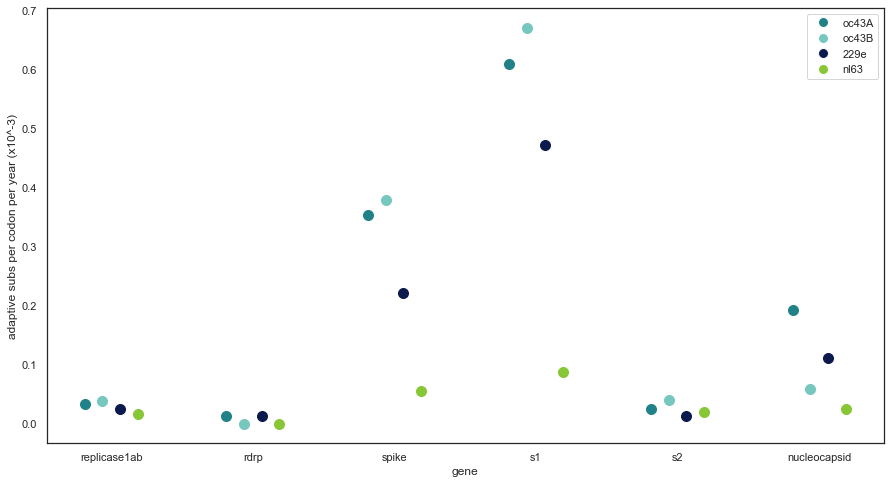

In [29]:
plot_adaptive_subs_per_codon_per_year_slope(['oc43', '229e', 'nl63'], ['replicase1ab', 'rdrp', 'spike', 's1', 
                                                                       's2', 'nucleocapsid'], 
                                            3, 2, 0.75, 0.15, False, 
                                            year_max=None, year_min=None, filename='adaptation_rates_across_genes.png')

In [52]:
#calculated as slope of adaptive subs per codon
def plot_adaptive_subs_per_codon_per_year_slope_no_hku1_lineages(covs, genes, window, min_seqs, midfreq_high, midfreq_low, bootstrap, year_max=None, year_min=None, filename=None):
    
    data_to_plot = []
    
    cov_clades = {'229e': [None], 'oc43': ['A', 'B'], 'nl63': [None], 'hku1': [None]}

    for cov in covs:
        clades = cov_clades[cov]
        for clade in clades:
            for gene in genes:
                if clade == None:
                    cov_clade = cov
                elif clade != None:
                    cov_clade = str(cov)+str(clade)

                
                if bootstrap:
                    if clade == None:
                        save_json_name = 'bhatt_results/'+str(cov)+'_'+str(gene)+'_bhatt_analysis_bootstrapped.json'
                    elif clade != None:
                        save_json_name = 'bhatt_results/'+str(cov)+str(clade)+'_'+str(gene)+'_bhatt_analysis_bootstrapped.json'
                    
                    if path.exists(save_json_name):
                        with open(save_json_name) as json_handle:
                            json_dict = json.load(json_handle)
                            (window_midpoint, adaptive_substitutions, 
                             adaptive_substitutions_per_codon, 
                             rate_of_adaptation, bootstrap_adaptive_substitutions, 
                             bootstrap_adaptive_substitutions_per_codon, 
                             bootstrap_rate_of_adaptation) = (json_dict['window_midpoint'], 
                                                              json_dict['adaptive_substitutions'], 
                                                              json_dict['adaptive_substitutions_per_codon'], 
                                                              json_dict['rate_of_adaptation'], 
                                                              json_dict['bootstrap_adaptive_substitutions'], 
                                                              json_dict['bootstrap_adaptive_substitutions_per_codon'], 
                                                              json_dict['bootstrap_rate_of_adaptation'])
                    
                    else:
                        (window_midpoint, adaptive_substitutions, 
                         adaptive_substitutions_per_codon, 
                         rate_of_adaptation, bootstrap_adaptive_substitutions, 
                         bootstrap_adaptive_substitutions_per_codon, 
                         bootstrap_rate_of_adaptation) = calc_bhatt_a(cov, gene, window, 
                                                                      clade, min_seqs, midfreq_high, 
                                                                      midfreq_low, bootstrap, year_max, year_min)
                        save_json = {'cov': cov, 'gene': gene, 'window':window, 'clade':clade, 'min_seqs': min_seqs, 
                                     'midfreq_high': midfreq_high, 'midfreq_low': midfreq_low,
                                     'window_midpoint':window_midpoint, 'adaptive_substitutions':adaptive_substitutions, 
                                     'adaptive_substitutions_per_codon':adaptive_substitutions_per_codon, 'rate_of_adaptation': rate_of_adaptation,
                                     'bootstrap_adaptive_substitutions': bootstrap_adaptive_substitutions, 
                                     'bootstrap_adaptive_substitutions_per_codon': bootstrap_adaptive_substitutions_per_codon, 
                                     'bootstrap_rate_of_adaptation':bootstrap_rate_of_adaptation}
                        with open(save_json_name, 'w') as outfile:
                            json.dump(save_json, outfile)

                    slope_sci = rate_of_adaptation * (10**3)
                    bs_slope_sci = [x * (10**3) for x in bootstrap_rate_of_adaptation]
                    lower_95ci = np.percentile(sorted(bs_slope_sci), 2.5)
                    upper_95ci = np.percentile(sorted(bs_slope_sci), 97.5)
                    
                    data_to_plot.append({'cov': cov, 'gene': gene, 'cov_clade': cov_clade,
                                         'adaptive_subs_per_codon_per_year': slope_sci, 
                                         'lower_95ci': lower_95ci, 'upper_95ci': upper_95ci, 
                                         'ci': [lower_95ci, upper_95ci]})
                    

                           
                else:
                    (window_midpoint, adaptive_substitutions, 
                     adaptive_substitutions_per_codon, 
                     rate_of_adaptation) = calc_bhatt_a(cov, gene, window, clade, min_seqs, 
                                                        midfreq_high, midfreq_low, 
                                                        bootstrap, year_max, year_min)
                    slope_sci = rate_of_adaptation * (10**3)
                    data_to_plot.append({'cov': cov, 'gene': gene, 'cov_clade': cov_clade,
                     'adaptive_subs_per_codon_per_year': slope_sci})
                
            

                
        
    df_to_plot = pd.DataFrame(data_to_plot)
    
    sns.set(font_scale=1.0)
    sns.set_style("white")
    
    color_map = {'oc43A': '#208288', 'oc43B':'#76C7BE',  '229e': '#0B194C', 
                 'nl63A': '#87C735', 'nl63B': '#009888', 'nl63': '#87C735',
                 'hku1A': '#2E74B3', 'hku1B': '#92B2DE', 'hku1': '#255191'}  
    
    cov_clades = list(df_to_plot['cov_clade'].unique())
    
    x_coords = {}
    
    all_x_ticks = []
    last_coord = 0.0
    for gene in genes:
        x_coords[gene] = {}
        for cov_clade in cov_clades:
            last_coord+=0.25
            x_coords[gene][cov_clade] = last_coord
            all_x_ticks.append(last_coord)
        last_coord+=1.0
    
    fig, ax = plt.subplots(figsize=(15,8))
    
    x_labels = []
    gene_ticks = []
    
    for gene in genes:
        gene_coords = list(x_coords[gene].values())
        gene_ticks.append(sum(gene_coords)/len(gene_coords))
        x_labels.append(gene)
        for cov_clade in cov_clades:
            x = x_coords[gene][cov_clade]
            df_row = df_to_plot[(df_to_plot['gene']==gene)&(df_to_plot['cov_clade']==cov_clade)]
            y = float(df_row['adaptive_subs_per_codon_per_year'])
            if bootstrap:
                err_lower = float(df_row['lower_95ci'])
                err_upper = float(df_row['upper_95ci'])
                ax.vlines( x, err_lower, err_upper)
            ax.plot(x, y, 'o', ms=14, color=color_map[cov_clade])
    
    
    plt.xticks(gene_ticks, x_labels)
    
    legend_markers = []
    for cov_clade in cov_clades:
        legend_markers.append(mlines.Line2D([0], [0], color='w', markerfacecolor=color_map[cov_clade], marker='o',
                                            markersize=12, label=cov_clade))
    plt.legend(handles=legend_markers, loc='upper right')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax.set_ylabel('adaptive subs per codon per year (x10^-3)', fontsize=16)
    ax.set_xlabel("gene", fontsize=16)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(14) 

    
    if filename:
        fig.savefig(filename, dpi=300)


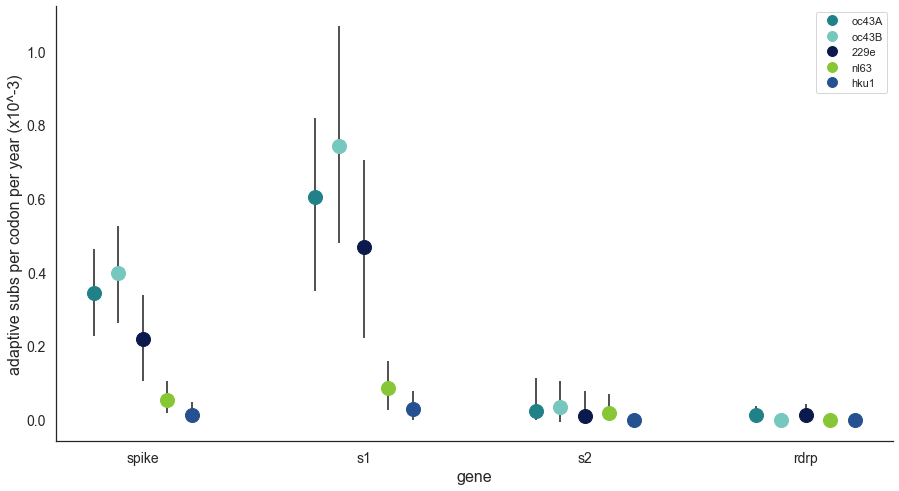

In [57]:
#oct 9: no nl63 or hku1 lineages
plot_adaptive_subs_per_codon_per_year_slope_no_hku1_lineages(['oc43', '229e', 'nl63', 'hku1'], 
                                                             ['spike','s1', 's2', 'rdrp'], 3, 3, 0.75, 0.15, True, 
                                                             filename='plots/adaptive_subs_per_year_100bootstraps_nolineages_dec18.png')

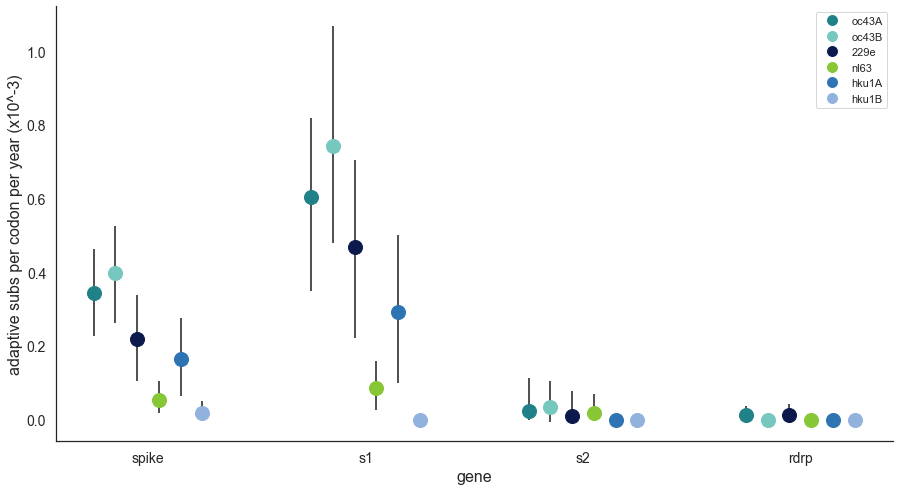

In [56]:
#oct 9: hku1 lineages, but no nl63
plot_adaptive_subs_per_codon_per_year_slope(['oc43', '229e', 'nl63', 'hku1'], 
                                            ['spike','s1', 's2', 'rdrp'], 3, 3, 0.75, 0.15, True, 
                                            filename='plots/adaptive_subs_per_year_100bootstraps_hku1lineages_dec18.png')

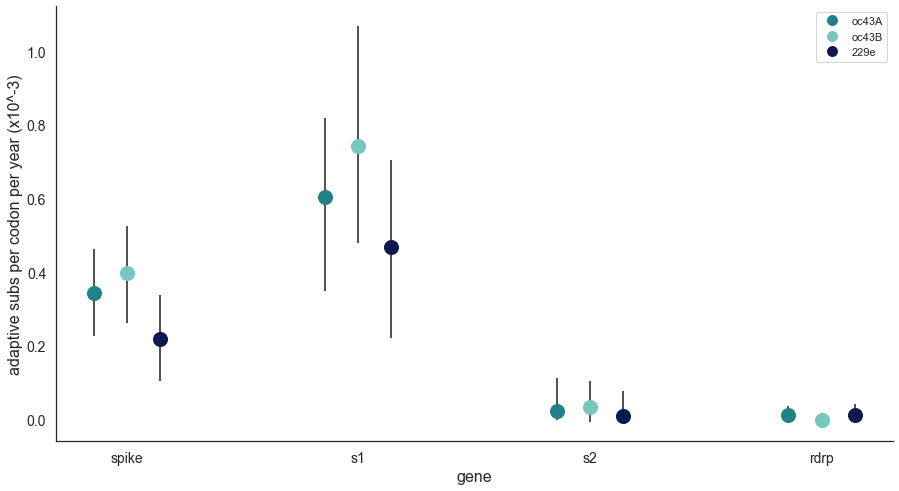

In [55]:
#sept 30: oc43 and 229e only
plot_adaptive_subs_per_codon_per_year_slope(['oc43','229e'], 
                                            ['spike','s1', 's2', 'rdrp'], 3, 3, 0.75, 0.15, True, 
                                           filename='fig5_dec18.png')


/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide
/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide


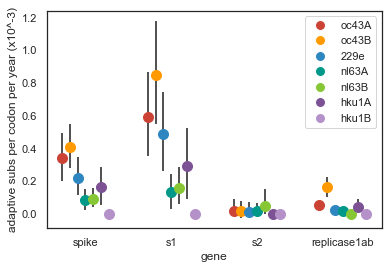

In [747]:
#Run with 1000 bootstraps

plot_adaptive_subs_per_codon_per_year_slope(['oc43','229e','nl63', 'hku1'], 
                                            ['spike','s1', 's2', 'replicase1ab'], 
                                            3, 3, 0.75, 0.15, True, filename='adaptive_subs_per_year_1000bootstraps.png')
